In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob, cython
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from scipy.ndimage.interpolation import map_coordinates

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, datasource

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%load_ext Cython


0.4.0


In [2]:
imwidth = 256
imheight = 256
numimgs = 1000

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(float),(image>0).astype(float)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

(1000, 256, 256, 1) (1000, 256, 256)
2.14 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 256, 256, 1) (1000, 256, 256)


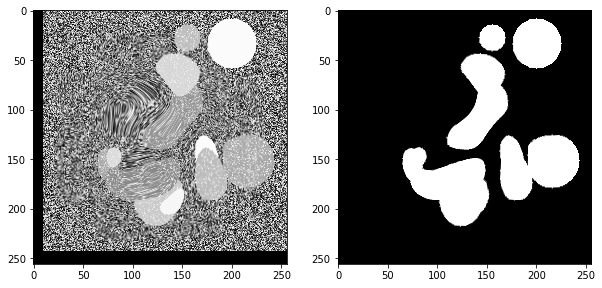

In [38]:
datasource=reload(datasource)


def mapImageChannels(image,indices):
    
    if len(image.shape)==2:
        result=map_coordinates(image,indices, order=1, mode='constant').reshape(image.shape)
    else:
        result=np.concatenate([mapImageChannels(image[...,i],indices) for i in range(image.shape[-1])])
        
    return result.reshape(image.shape)
    
    
def deformBothAugmentPIL(image,seg,defrange=25,numControls=3,margin=2):
    h,w = image.shape[:2]
    
    imshift=np.zeros((2,numControls+margin*2,numControls+margin*2))
    imshift[:,margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(2,numControls,numControls))

    imshiftx=np.array(Image.fromarray(imshift[0]).resize((w,h),Image.QUAD))
    imshifty=np.array(Image.fromarray(imshift[1]).resize((w,h),Image.QUAD))
        
    y, x = np.meshgrid(np.arange(w), np.arange(h))
    indices =  np.reshape(x+imshiftx, (-1, 1)),np.reshape(y+imshifty, (-1, 1))

    imagedef= mapImageChannels(image,indices)
    segdef=mapImageChannels(seg,indices)
    return imagedef,segdef


def deformBothAugmentPIL1(imageShape,segShape,defRange=25,numControls=3,margin=2):
    assert len(imageShape) in (2,3)
    
    h,w=imageShape[:2]
    imshiftx=np.zeros((numControls+margin*2,numControls+margin*2))
    imshifty=np.zeros((numControls+margin*2,numControls+margin*2))
    
    meshy, meshx = np.meshgrid(np.arange(w), np.arange(h))
    
    def _apply(image,seg):
        imshiftx[margin:-margin,margin:-margin]=np.random.randint(-defRange,defRange,(numControls,numControls))
        imshiftxR=np.array(Image.fromarray(imshiftx).resize((w,h),Image.QUAD))

        imshifty[margin:-margin,margin:-margin]=np.random.randint(-defRange,defRange,(numControls,numControls))
        imshiftyR=np.array(Image.fromarray(imshifty).resize((w,h),Image.QUAD))

        indices =  np.reshape(meshx+imshiftxR, (-1, 1)),np.reshape(meshy+imshiftyR, (-1, 1))

        imagedef=mapImageChannels(image,indices)
        segdef=mapImageChannels(seg,indices)
        return imagedef,segdef
    
    return _apply


print(imgin.shape,maskin.shape)
# di,dm=deformBothAugmentPIL(imgin[0],maskin[0])

# %timeit deformBothAugmentPIL(imgin[0],maskin[0])

# print(di.shape,dm.shape)
# plotPair(di[0],dm)

augs=[
    lambda i,m:(i,m.astype(np.float32)),
    trainimagesource.rot90BothAugment, trainimagesource.transposeBothAugment,trainimagesource.flipBothAugment,
    partial(trainimagesource.shiftMaskAugment,dimfract=15,order=0),
    deformBothAugmentPIL,#1(imgin.shape[1:],maskin.shape[1:])
#     pytorchutils.convertAug
]

dsrc=datasource.DataSource(imgin,maskin,augments=augs)

# %timeit dsrc.getIndexBatch(np.arange(numimgs))
# %timeit dsrc.getRandomBatch(numimgs)

with dsrc.threadBatchGen(numimgs) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
plotPair(imgs[0,...,0],masks[0])

# with dsrc.processBatchGen(numimgs) as gen:
#     imgs,masks=gen()
#     %timeit gen()

# print(imgs.shape,masks.shape)
# plotPair(imgs[0,...,0],masks[0])

6.01 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


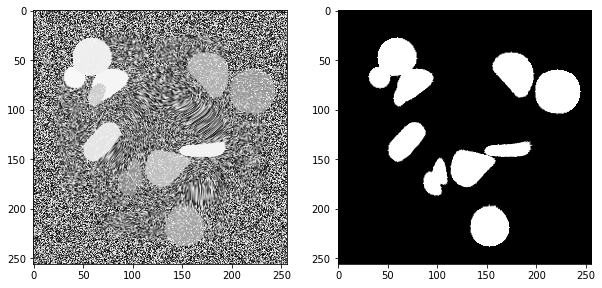

In [37]:
def mapImageChannels1(image,indices):
    
    if len(image.shape)==2:
        result=map_coordinates(image,indices, order=1, mode='constant').reshape(image.shape)
    else:
        result=np.concatenate([mapImageChannels(image[...,i],indices) for i in range(image.shape[-1])])
        
    return result.reshape(image.shape)
    
    
def deformBothAugmentPIL1(image,seg,defrange=25,numControls=3,margin=2):
    h,w = image.shape[:2]
    
    imshift=np.zeros((2,numControls+margin*2,numControls+margin*2))
    imshift[:,margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(2,numControls,numControls))

    imshiftx=np.array(Image.fromarray(imshift[0]).resize((w,h),Image.QUAD))
    imshifty=np.array(Image.fromarray(imshift[1]).resize((w,h),Image.QUAD))
    
        
    y, x = np.meshgrid(np.arange(w), np.arange(h))
    indices =  np.reshape(x+imshiftx, (-1, 1)),np.reshape(y+imshifty, (-1, 1))

    imagedef= mapImageChannels1(image,indices)
    segdef=mapImageChannels1(seg,indices)
    return imagedef,segdef

%timeit deformBothAugmentPIL1(imgin[0],maskin[0])
imgs,masks=deformBothAugmentPIL1(imgin[0],maskin[0])
plotPair(imgs[...,0],masks)
